## MNIST <span style="font-size: 15px;">`Modified National Institute of Standards and Technology`</span>



## 🧠 Imports

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## 🔧 Config

In [2]:
EPOCHS = 100
BATCH_SIZE = 128
MODEL_PATH = "models\mnist_model_final.keras"
FEATURE_EXTRACTOR = "models\mnist_feature_extractor.keras"

## ⏳ Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

##### 📈 Plot Sample

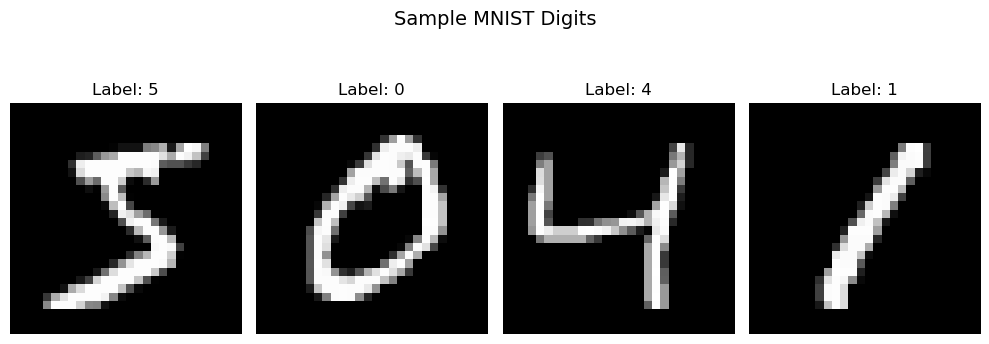

In [4]:
# Plot 3 sample images
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
fig.suptitle("Sample MNIST Digits", fontsize=14)

for i in range(4):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].set_title(f"Label: {np.argmax(y_train[i])}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

##### 💾 Save Test Data

In [5]:
# Create save directory
save_dir = "MNIST Test Images"
os.makedirs(save_dir, exist_ok=True)

# Save images
for i, (img_arr, label) in enumerate(zip(list(x_test), list(np.argmax(y_test, axis=1)))):
    # Ensure it's 2D (28x28)
    if img_arr.ndim == 3:
        img_arr = np.squeeze(img_arr)

    # Convert to uint8 if needed
    if img_arr.dtype != np.uint8:
        img_arr = (img_arr * 255).astype(np.uint8)

    # Convert and save
    img = Image.fromarray(img_arr)
    img.save(os.path.join(save_dir, f"{label}_{i}.png"), format="PNG")

## 🛠️ Modeling

In [6]:
input_layer = Input(shape=(28, 28, 1), name="input")

conv1 = Conv2D(32, (3,3), activation='relu', name="conv1")(input_layer)
pool1 = MaxPooling2D((2,2), name="pool1")(conv1)

conv2 = Conv2D(64, (3,3), activation='relu', name="conv2")(pool1)
pool2 = MaxPooling2D((2,2), name="pool2")(conv2)

flat = Flatten(name="flatten")(pool2)
dense = Dense(64, activation='relu', name="dense1")(flat)

drop = Dropout(0.5)(dense)
output = Dense(10, activation='softmax', name="output")(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Training

In [7]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint("models\mnist_model_best.keras", save_best_only=True, monitor="val_loss") # , verbose=1
]

# Train
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.7389 - loss: 0.7985 - val_accuracy: 0.9757 - val_loss: 0.0782 - learning_rate: 0.0010
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9522 - loss: 0.1622 - val_accuracy: 0.9840 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9642 - loss: 0.1192 - val_accuracy: 0.9885 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9683 - loss: 0.1046 - val_accuracy: 0.9882 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9727 - loss: 0.0913 - val_accuracy: 0.9889 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9790 - loss: 0.0726 - val_accuracy: 0.9887 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9766

##### 📈 Plot History 

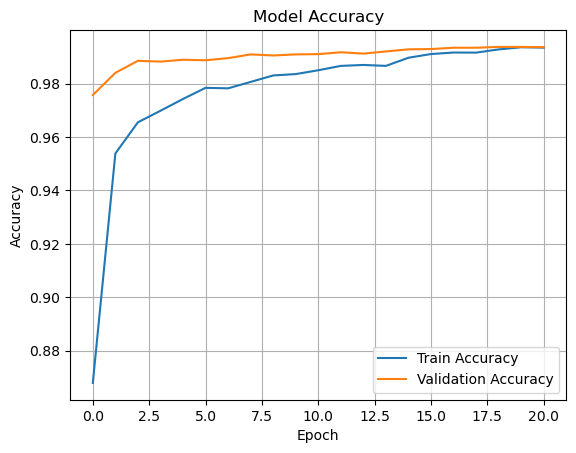

🧪 Test Accuracy: 0.9929, Test Loss: 0.0226


In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 🔍 Evaluate Model
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"🧪 Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 1000x800 with 0 Axes>

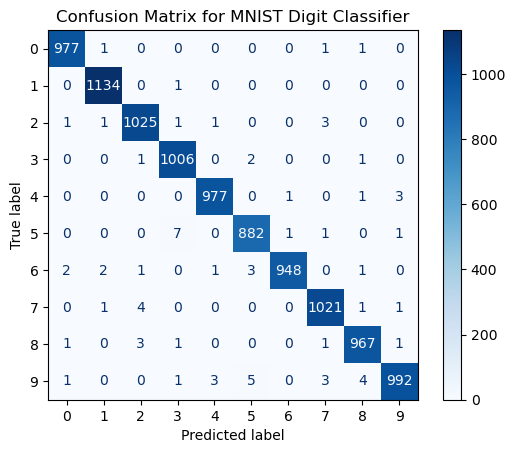

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels of the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for MNIST Digit Classifier")
plt.show()

### 💾 Save

In [10]:
# Save final model
model.save(MODEL_PATH)
print(f"✅ Final model saved as {MODEL_PATH}")

# Create a feature extractor model (for visualization)
conv_outputs = [model.get_layer("conv1").output, model.get_layer("conv2").output]
feature_extractor = Model(inputs=model.input, outputs=conv_outputs)
feature_extractor.save(FEATURE_EXTRACTOR)
print(f"🔍 Feature extractor model saved as {FEATURE_EXTRACTOR}!")

✅ Final model saved as models\mnist_model_final.keras
🔍 Feature extractor model saved as models\mnist_feature_extractor.keras!
